#### Imports

In [6]:

import os
import pandas as pd
# import librosa
import glob
# import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# from tensorflow.keras import to_categorical

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import np_utils
from sklearn import metrics

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import os

AttributeError: type object 'h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'

In [16]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# from keras.utils.np_utils import to_categorical

from tensorflow.keras.utils import to_categorical


In [ ]:
# pip install librosa

#### Reading the files from our folder and creating a dataframe from it

In [ ]:
#list the files
filelist = os.listdir('male') 
#read them into pandas
df_male = pd.DataFrame(filelist)

In [ ]:
# Adding the 1 label to the dataframe representing male
df_male['label']='1'

In [ ]:
# Renaming the column name to file
df_male = df_male.rename(columns={0:'file'})

In [ ]:
df_male.head()

,file,label
0,2893-139322-0000.flac,1
1,1034-121119-0071.flac,1
2,78-369-0018.flac,1
3,322-124147-0038.flac,1
4,831-130739-0049.flac,1


In [ ]:
# Checking for a file that gets automatically generated and we need to drop 
df_male[df_male['file']=='.DS_Store']

,file,label


Doing the same for the female folder

In [ ]:
filelist = os.listdir('female') 
#read them into pandas
df_female = pd.DataFrame(filelist)

In [ ]:
df_female['label']='0'

In [ ]:
df_female = df_female.rename(columns={0:'file'})

In [ ]:
df_female.head()

,file,label
0,441-128982-0010.flac,0
1,1502-122619-0039.flac,0
2,302-123504-0010.flac,0
3,1553-140048-0029.flac,0
4,32-21625-0013.flac,0


In [ ]:
# Checking for a file that gets automatically generated and we need to drop 
df_female[df_female['file']=='.DS_Store']

,file,label
981,.DS_Store,0


In [ ]:
# Dropping the system file
df_female.drop(981, inplace=True)

In [ ]:
# Resetting the index since we dropped a row
df_female = df_female.reset_index(drop=True)

Joining both dataframes together 

In [ ]:
df = pd.concat([df_female, df_male], ignore_index=True)

In [ ]:
df.head()

,file,label
0,441-128982-0010.flac,0
1,1502-122619-0039.flac,0
2,302-123504-0010.flac,0
3,1553-140048-0029.flac,0
4,32-21625-0013.flac,0


In [ ]:
# Randomizing our files to be able to split into train, validation and test
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# We will be using our saved randomized df to replicate results
# Any randomized df can be used but we already had the features for this randomized df

# df = pd.read_csv('randomized_df.csv')

We are going to do an split of train, validation and test with 70% train, 20% validation and 10% for test. We check that the randomized splits have balanced classes

In [ ]:
df_train = df[:9188]

In [ ]:
df_train['label'].value_counts(normalize=True)

0    0.501633
1    0.498367
Name: label, dtype: float64

In [ ]:
df_validation = df[9188:11813]

In [ ]:
df_validation['label'].value_counts(normalize=True)

1    0.502476
0    0.497524
Name: label, dtype: float64

In [ ]:
df_test = df[11813:13125]

In [ ]:
df_test['label'].value_counts(normalize=True)

1    0.500762
0    0.499238
Name: label, dtype: float64

#### Function to extract the features and label for each sound file by iterating through every row of the dataframe

In [ ]:
# Although this function was modified and many parameteres were explored with, most of it 
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('voice')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [ ]:
# Code to start the timer to see how long it takes to extract the features
startTime = datetime.now()

In [ ]:
# Applying the function to the train data by accessing each row of the dataframe
features_label = df.apply(extract_features, axis=1)

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [ ]:
# Code to see how long it took
print(datetime.now() - startTime)

2:53:17.949280


In [ ]:
# Checking how the output looks
features_label

array([(array([-366.63562   ,   96.04874   ,  -69.84662   ,   76.36943   ,
        -24.817017  ,   14.41616   ,    4.2905197 ,   -1.8795805 ,
         13.70058   ,    3.6543803 ,    8.991205  ,   -3.1601498 ,
          5.1049666 ,    2.6289887 ,    1.0638338 ,   -3.784181  ,
          1.1059349 ,    1.8543453 ,    2.2196708 ,    3.0452476 ,
          2.9182453 ,    4.099081  ,    0.39878955,    5.7587442 ,
          0.7864756 ,    3.3036218 ,    1.7996112 ,   -0.8484667 ,
          3.3366387 ,    2.934917  ,    2.9008343 ,    0.5252678 ,
          2.3906317 ,    1.9600887 ,    2.8523176 ,    3.2463658 ,
          3.8902597 ,    4.625333  ,    3.8027694 ,    5.2710724 ],
      dtype=float32), array([0.55214745, 0.5712805 , 0.598977  , 0.60294086, 0.61977226,
       0.6546082 , 0.64055675, 0.62010676, 0.586103  , 0.58701015,
       0.6026565 , 0.5885016 ], dtype=float32), array([7.36393154e-01, 2.26960018e-01, 1.12153115e-02, 6.72356132e-03,
       1.60283357e-01, 1.04996264e+00, 1.69271

In [ ]:
# Saving the numpy array because it takes a long time to extract the features
np.save('features_label', features_label)

In [ ]:
# loading the features
features_label = np.load('features_label.npy', allow_pickle=True)

In [ ]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [ ]:
len(features)

13125

In [ ]:
# Similarly, we create a list where we will store all the labels

labels = []
for i in range(0, len(features_label)):
    labels.append(features_label[i][5])

In [ ]:
len(labels)

13125

#### Checking if we have balanced classes for the whole data

In [ ]:
np.unique(labels, return_counts=True)

(array(['0', '1'], dtype='<U1'), array([6570, 6555]))

#### Hot encoding y and pre processing X and y

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive
# %cd MyDrive/result_files
df_audio = pd.read_hdf('data_with_gender.h5',  'data')

NameError: name 'pd' is not defined

In [3]:
df_audio.columns[list(range(720))]

Index(['timestamp', 'confidence', 'gaze_0_x', 'gaze_0_y', 'gaze_0_z',
       'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 'gaze_angle_x', 'gaze_angle_y',
       ...
       'AU45_c', 'question', 'person_id', 'WC', 'OtherP', 'y',
       'positive_assumption', 'negative_assumption',
       'What is your age (in years) ?', 'Gender_Male'],
      dtype='object', length=720)

In [4]:
df_audio = df_audio[df_audio.columns[list(range(720))]]

In [5]:
df_audio.columns

Index(['timestamp', 'confidence', 'gaze_0_x', 'gaze_0_y', 'gaze_0_z',
       'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 'gaze_angle_x', 'gaze_angle_y',
       ...
       'AU45_c', 'question', 'person_id', 'WC', 'OtherP', 'y',
       'positive_assumption', 'negative_assumption',
       'What is your age (in years) ?', 'Gender_Male'],
      dtype='object', length=720)

In [6]:
import random
random.seed(0)
samples= list(df_audio.person_id.unique())
num_samples = len(samples)

In [7]:
tv_ids = samples[:round(0.9*num_samples)]
test_ids = list(set(samples)-set(tv_ids)) 
train_ids = samples[:round(0.63*len(tv_ids))]
val_ids = list(set(tv_ids)-set(train_ids))
print(train_ids,samples)
df_train=pd.DataFrame()
for i in train_ids:
  df_train=df_train.append(df_audio[df_audio['person_id']==i])

df_val=pd.DataFrame()
for i in val_ids:
  df_val=df_val.append(df_audio[df_audio['person_id']==i])


df_test=pd.DataFrame()
for i in test_ids:
  df_test=df_test.append(df_audio[df_audio['person_id']==i])

[3, 2, 1, 5, 9, 4, 8, 7, 6, 10, 13, 15, 14, 11, 12, 17] [3, 2, 1, 5, 9, 4, 8, 7, 6, 10, 13, 15, 14, 11, 12, 17, 16, 24, 23, 19, 21, 20, 22, 18, 25, 30, 31, 28]


In [8]:
df_train.shape, df_val.shape

((454697, 720), (312220, 720))

In [18]:
X_train = df_train.drop('y',axis=1)
X_test = df_test.drop('y',axis=1)
X_val = df_val.drop('y',axis=1)
y_train = df_train['y']
y_test = df_test['y']
y_val = df_val['y']

In [19]:
# Setting our X as a numpy array to feed into the neural network
# X = np.array(df_audio.drop('y',axis=1))

In [20]:
# Setting our y
# y = np.array(df_audio.y)

In [21]:
# Hot encoding y
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))
y_test = to_categorical(lb.fit_transform(y_test))

In [ ]:
# # Choosing the first 9188 (70%) files to be our train data
# # Choosing the next  2625 (20%) files to be our validation data
# # Choosing the next  1312 (10%) files to be our test never before seen data
# # This is analogous to a train test split but we add a validation split and we are making
# # we do not shuffle anything since we are dealing with several time series, we already 
# # checked before that we have balanced classes (analogous to stratify)

# X_train = X[:499]
# y_train = y[:499]

# X_val = X[499:777]
# y_val = y[499:777]

# X_test = X[777:]
# y_test = y[777:]

Scaling our data

In [22]:
from sklearn.preprocessing import StandardScaler
col_transform =list(X_train.columns)
col_transform.remove('person_id')
col_transform.remove('positive_assumption')
col_transform.remove('negative_assumption')
col_transform.remove('question')
col_transform.remove('Gender_Male')
scale = StandardScaler().fit(X_train[col_transform])
X_train[col_transform] = pd.DataFrame(scale.transform(X_train[col_transform]),columns=col_transform)
X_test[col_transform] = pd.DataFrame(scale.transform(X_test[col_transform]),columns=col_transform)
X_val[col_transform] = pd.DataFrame(scale.transform(X_val[col_transform]),columns=col_transform)

# X_test = scale.transform(X_test)

In [23]:
X_train.to_hdf('video_dataset_split/X_train.h5','data')
X_test.to_hdf('video_dataset_split/X_test.h5','data')
X_val.to_hdf('video_dataset_split/X_val.h5','data')



AttributeError: 'numpy.ndarray' object has no attribute 'to_hdf'

In [25]:
pd.DataFrame(y_train).to_hdf('video_dataset_split/y_train.h5','data')
pd.DataFrame(y_test).to_hdf('video_dataset_split/y_test.h5','data')
pd.DataFrame(y_val).to_hdf('video_dataset_split/y_val.h5','data')

#### Building the neural network

In [ ]:
X_train.shape

(499, 501)

In [ ]:
# Build a simple dense model with early stopping with softmax for categorical classification
# Note that we use softmax for binary classification because it gives us a better result
# than sigmoid for our probabilities in case we decide to use a voting classifier 

model = Sequential()

model.add(Dense(25, input_shape=(501,), activation = 'relu'))
model.add(Dropout(0.5))

# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.25))  

# model.add(Dense(501, activation = 'relu'))
# model.add(Dropout(0.5))    

model.add(Dense(2, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 15
history = model.fit(X_train, y_train, batch_size=256, epochs=200, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])
                    

Epoch 1/200
2/2 [==============================] - 1s 181ms/step - loss: 0.9982 - accuracy: 0.5431 - val_loss: 0.7749 - val_accuracy: 0.5612
Epoch 2/200
2/2 [==============================] - 0s 33ms/step - loss: 0.8807 - accuracy: 0.5271 - val_loss: 0.7537 - val_accuracy: 0.5540
Epoch 3/200
2/2 [==============================] - 0s 39ms/step - loss: 0.8087 - accuracy: 0.5691 - val_loss: 0.7255 - val_accuracy: 0.5719
Epoch 4/200
2/2 [==============================] - 0s 33ms/step - loss: 0.8196 - accuracy: 0.5711 - val_loss: 0.7161 - val_accuracy: 0.5683
Epoch 5/200
2/2 [==============================] - 0s 31ms/step - loss: 0.8100 - accuracy: 0.5551 - val_loss: 0.7166 - val_accuracy: 0.5719
Epoch 6/200
2/2 [==============================] - 0s 32ms/step - loss: 0.8174 - accuracy: 0.5671 - val_loss: 0.7106 - val_accuracy: 0.5612
Epoch 7/200
2/2 [==============================] - 0s 32ms/step - loss: 0.7361 - accuracy: 0.5892 - val_loss: 0.7081 - val_accuracy: 0.5755
Epoch 8/200
2/2 [==

In [ ]:
# Checking how our model looks like and how many parameters it has
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 25)                12550     
_________________________________________________________________
dropout_18 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 52        
Total params: 12,602
Trainable params: 12,602
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

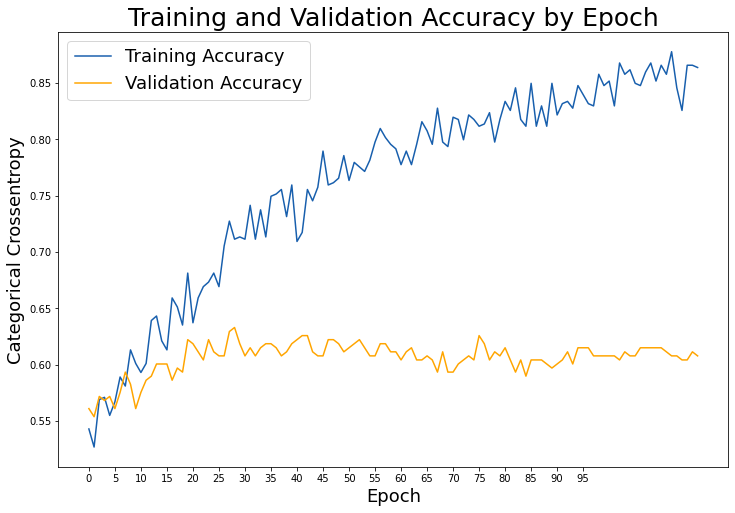

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [ ]:
# Using our model to get the predictions for our test data
preds = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
df_test = df_audio[777:]

In [ ]:
df_test['preds'] = preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,id,y,preds
777,0.845551,0.580830,1.53,0.24,0.189573,0.006172,0.035876,0.098366,0.030667,0.093157,0.053141,0.24,0.264442,0.000014,0.58,-0.060141,0.040109,0.055341,0.044910,0.100251,-0.437825,1.026074,0.179784,2.01,0.24,0.367689,0.000375,-0.120989,-0.006732,0.028487,0.035220,0.149477,0.610000,0.000000,-0.003319,0.002992,0.003286,0.003025,0.006311,-0.027700,...,2.861875,3.785531,4.721305,4.721305,194.13297,3.000932,3.772050,5.080466,5.080466,187.93672,2.717421,3.635094,189.35164,200.82259,3.384684,4.235768,5.429082,5.429082,198.01650,197.56601,2.578053,3.435338,4.174616,4.174616,189.45644,178.64786,2.691314,3.347195,167.39886,17.164133,2.007938,2.509624,3.161174,3.161174,139.11168,139.90956,36.0,27,1,1
778,0.709642,0.461652,2.14,0.76,0.260467,0.007952,0.025608,0.091601,0.021069,0.087062,0.058799,0.77,0.294889,0.000020,0.84,-0.075326,0.036404,0.069809,0.041921,0.111730,-0.490910,1.143785,0.200844,2.50,0.76,0.406085,0.000486,-0.115607,-0.004692,0.036961,0.041654,0.152568,0.930000,0.000000,-0.003984,0.002310,0.003913,0.002381,0.006294,-0.030145,...,2.956037,3.817420,4.766262,4.766262,188.10138,2.802487,3.647505,4.633435,4.633435,192.78078,2.805498,3.562533,186.93300,184.57425,3.480308,4.361070,5.472799,5.472799,206.56355,206.74191,2.689050,3.606376,4.352905,4.352905,188.39091,185.32126,2.737878,3.473157,179.95229,17.774916,1.964001,2.524725,3.193822,3.193822,142.01788,140.63327,83.0,27,0,1
779,0.737881,0.452955,1.88,0.94,0.204831,0.007618,0.027154,0.081754,0.021463,0.076063,0.053156,0.94,0.289575,0.000020,0.96,-0.090610,0.053676,0.083907,0.060379,0.144285,-0.454818,1.071220,0.202320,2.30,0.94,0.313224,0.000464,-0.139886,-0.010432,0.061539,0.071971,0.201425,0.960000,0.000000,-0.004236,0.003458,0.004123,0.003571,0.007694,-0.029825,...,3.316481,4.124999,5.141478,5.141478,200.81479,3.196942,4.045713,5.267701,5.267701,200.94928,2.977041,3.807562,195.48082,196.74516,3.734232,4.633805,5.815381,5.815381,214.88130,229.17624,2.896484,3.805808,4.610575,4.610575,199.33199,195.25136,2.741961,3.447050,179.72658,15.266617,2.200287,2.780517,3.501530,3.501530,147.62845,148.97818,55.0,27,1,1
780,0.460412,0.279599,2.37,0.16,0.367520,0.007852,0.013446,0.074620,0.010981,0.072155,0.062150,0.16,0.480856,0.000026,0.54,-0.053119,0.018721,0.050233,0.021606,0.071840,-0.517284,1.223564,0.203813,2.45,0.16,0.479843,0.000494,-0.100740,-0.001251,0.025888,0.027138,0.126627,0.570000,0.000000,-0.002609,0.001780,0.002588,0.001800,0.004389,-0.038894,...,3.318208,4.189857,5.109667,5.109667,207.94200,2.808533,3.428136,4.492912,4.492912,178.01918,2.687662,3.552862,191.33908,177.59094,3.167303,4.078606,5.023317,5.023317,192.32390,188.60217,2.581710,3.347279,4.194714,4.194714,177.92130,184.14429,2.465064,3.091791,163.80617,13.287749,2.029167,2.522704,3.151887,3.151887,133.24025,132.90695,6.0,27,0,1
781,0.786746,0.535075,3.51,1.19,0.338943,0.008007,0.029119,0.095253,0.024999,0.091133,0.059125,1.19,0.379805,0.000021,119.56,-0.076800,0.036780,0.071400,0.042180,0.113580,-0.495058,1.171634,0.203728,3.52,1.19,0.513668,0.000482,-0.118873,-0.005900,0.036299,0.042199,0.155171,0.000000,0.000000,-0.003875,0.002521,0.003798,0.002598,0.006396,-0.031339,...,2.922819,3.755510,4.794976,4.794976,186.76613,2.879798,3.706017,4.702303,4.702303,187.39102,2.822317,3.655958,189.83470,191.27390,3.515781,4.409909,5.880336,5.880336,203.16203,217.37102,2.750181,3.674963,4.709652,4.709652,190.18994,186.67516,2.579819,3.304260,174.05700,14.741663,2.043772,2.590438,3.184824,3.184824,138.50710,139.40176,17.0,27,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
df_test['label'] = df_test['y'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Slicing our dataframe into the files we got wrong from our predictions
df_test[df_test['label'] != df_test['preds']]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,id,y,preds,label
778,0.709642,0.461652,2.14,0.76,0.260467,0.007952,0.025608,0.091601,0.021069,0.087062,0.058799,0.77,0.294889,0.000020,0.84,-0.075326,0.036404,0.069809,0.041921,0.111730,-0.490910,1.143785,0.200844,2.50,0.76,0.406085,0.000486,-0.115607,-0.004692,0.036961,0.041654,0.152568,0.930000,0.000000,-0.003984,0.002310,0.003913,0.002381,0.006294,-0.030145,...,3.817420,4.766262,4.766262,188.10138,2.802487,3.647505,4.633435,4.633435,192.78078,2.805498,3.562533,186.93300,184.57425,3.480308,4.361070,5.472799,5.472799,206.56355,206.74191,2.689050,3.606376,4.352905,4.352905,188.39091,185.32126,2.737878,3.473157,179.95229,17.774916,1.964001,2.524725,3.193822,3.193822,142.017880,140.633270,83.0,27,0,1,0
780,0.460412,0.279599,2.37,0.16,0.367520,0.007852,0.013446,0.074620,0.010981,0.072155,0.062150,0.16,0.480856,0.000026,0.54,-0.053119,0.018721,0.050233,0.021606,0.071840,-0.517284,1.223564,0.203813,2.45,0.16,0.479843,0.000494,-0.100740,-0.001251,0.025888,0.027138,0.126627,0.570000,0.000000,-0.002609,0.001780,0.002588,0.001800,0.004389,-0.038894,...,4.189857,5.109667,5.109667,207.94200,2.808533,3.428136,4.492912,4.492912,178.01918,2.687662,3.552862,191.33908,177.59094,3.167303,4.078606,5.023317,5.023317,192.32390,188.60217,2.581710,3.347279,4.194714,4.194714,177.92130,184.14429,2.465064,3.091791,163.80617,13.287749,2.029167,2.522704,3.151887,3.151887,133.240250,132.906950,6.0,27,0,1,0
783,0.716172,0.447308,2.56,0.36,0.303056,0.007374,0.028474,0.097542,0.023847,0.092915,0.061373,0.36,0.447081,0.000020,0.64,-0.069767,0.038336,0.063629,0.044475,0.108104,-0.493579,1.195543,0.205014,3.26,0.36,0.635753,0.000465,-0.114513,-0.007436,0.037312,0.044748,0.151825,0.740000,0.000000,-0.003974,0.002796,0.003902,0.002868,0.006770,-0.032452,...,3.684647,4.567672,4.567672,185.08037,2.952551,3.674990,4.529398,4.529398,183.46675,2.718839,3.411946,182.13904,174.93172,3.792829,4.664087,5.897371,5.897371,203.21167,217.80254,2.773354,3.603728,4.336888,4.336888,188.47697,184.80128,2.708217,3.456130,182.20770,14.439077,1.953593,2.501353,3.214098,3.214098,137.570110,139.023000,37.0,27,0,1,0
784,0.674629,0.446154,2.55,0.78,0.314676,0.007719,0.024428,0.088892,0.020786,0.085251,0.056997,0.78,0.392959,0.000020,0.85,-0.071992,0.031816,0.067329,0.036479,0.103808,-0.469747,1.128531,0.197468,3.32,0.78,0.555008,0.000474,-0.119101,-0.006164,0.032221,0.038385,0.151322,0.880000,0.000000,-0.003744,0.002067,0.003691,0.002120,0.005811,-0.030270,...,3.806748,4.762305,4.762305,193.91374,2.821737,3.729029,4.882239,4.882239,188.62646,2.877813,3.707271,191.04660,189.43683,3.566379,4.479893,5.818439,5.818439,205.14754,214.96883,2.826162,3.728378,4.590511,4.590511,190.75003,188.16243,2.630438,3.361892,176.41527,14.080251,2.043279,2.613914,3.313888,3.313888,141.600860,142.423080,79.0,27,0,1,0
787,0.714423,0.457322,1.56,0.41,0.213446,0.006916,0.024994,0.081961,0.020363,0.077329,0.058234,0.41,0.331554,0.000016,0.67,-0.070995,0.033811,0.065123,0.039683,0.104806,-0.460801,1.127977,0.193455,3.31,0.41,0.751132,0.000419,-0.109478,-0.007847,0.031614,0.039460,0.141092,0.710000,0.000000,-0.003331,0.002045,0.003224,0.002152,0.005376,-0.031209,...,3.776072,4.787026,4.787026,184.67873,2.799115,3.536468,4.254092,4.254092,174.00253,2.922910,3.731805,188.96147,190.19522,3.303284,4.108135,5.492443,5.492443,195.20741,197.44037,2.816493,3.705682,4.525498,4.525498,198.77940,188.51816,2.472549,3.140519,174.90259,12.691299,1.930105,2.461141,3.419568,3.419568,135.769010,137.583630,46.0,27,0,1,0
788,0.664632,0.389758,1.86,0.44,0.238106,0.006176,0.025291,0.090648,0.020591,0.085948,0.060191,0.44,0.375181,0.000017,0.68,-0.063570,0.046928,0.058362,0.052135,0.110497,-0.503349,1.092255,0.186843,3.06,0.45,0.583448,0.000382,-0.107817,-0.007248,0.047063,0.0543

In [ ]:
1-round(len(df_test[df_test['label'] != df_test['preds']])/len(df_test),3)

0.558

#### 99.8% accurate on test data

But it is test data from the speakers we have trained the model on

In [ ]:
#Checking how many different speakers we have

speakers = []
for i in range(0, len(df)):
    # The first numbers of each file represent the id of the speaker 
    speakers.append(df['file'][i].split('-')[0])

len(set(speakers))

115

#### We will try again and add new test data with speakers that our model has never heard before

In [ ]:
#list the files
filelist = os.listdir('test_male') 
#read them into pandas
df_test_male = pd.DataFrame(filelist)

# Adding the 1 label to the dataframe representing male
df_test_male['label']=1

# Renaming the column name to file
df_test_male = df_test_male.rename(columns={0:'file'})

df_test_male.head()

# Checking for a file that gets automatically generated and we need to drop 
df_test_male[df_test_male['file']=='.DS_Store']

,file,label
6,.DS_Store,1


In [ ]:
# Dropping the system file
df_test_male.drop(6, inplace=True)

# Resetting the index since we dropped a row
df_test_male = df_test_male.reset_index(drop=True)

In [ ]:
df_test_male.head()

,file,label
0,5104-33406-0000.flac,1
1,5192-19396-0000.flac,1
2,3607-29116-0008.flac,1
3,6181-216552-0000.flac,1
4,5390-24512-0000.flac,1


In [ ]:
#list the files
filelist = os.listdir('test_female') 
#read them into pandas
df_test_female = pd.DataFrame(filelist)

# Adding the 1 label to the dataframe representing male
df_test_female['label']=0

# Renaming the column name to file
df_test_female = df_test_female.rename(columns={0:'file'})

df_test_female.head()

# Checking for a file that gets automatically generated and we need to drop 
df_test_female[df_test_female['file']=='.DS_Store']

,file,label
7,.DS_Store,0


In [ ]:
# Dropping the system file
df_test_female.drop(7, inplace=True)

# Resetting the index since we dropped a row
df_test_female = df_test_female.reset_index(drop=True)

In [ ]:
df_test_female.head()

,file,label
0,2910-131096-0007.flac,0
1,5778-12761-0000.flac,0
2,4680-16026-0000.flac,0
3,6272-70168-0000.flac,0
4,5867-48852-0000.flac,0


In [ ]:
test_new = pd.concat([df_test_male, df_test_female], ignore_index=True)

In [ ]:
test_new.head()

,file,label
0,5104-33406-0000.flac,1
1,5192-19396-0000.flac,1
2,3607-29116-0008.flac,1
3,6181-216552-0000.flac,1
4,5390-24512-0000.flac,1


In [ ]:
#Checking how many different new speakers we have

speakers = []
for i in range(0, len(test_new)):
    # The first numbers of each file represent the id of the speaker 
    speakers.append(test_new['file'][i].split('-')[0])

len(set(speakers))

100

In [ ]:
# Again, the modified function to extract features from our new test data

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('new_test_male_female')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [ ]:
# Extracting the features of our new test data
features_label_test_new = test_new.apply(extract_features, axis=1)

In [ ]:
os.system('say -v Samantha done');

In [ ]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 
# Note that we are not using the label at all even though we kept it in the dataframe
# for comparisson and accuracy verification

features_new_test = []
for i in range(0, len(features_label_test_new)):
    features_new_test.append(np.concatenate((features_label_test_new[i][0], features_label_test_new[i][1], 
                features_label_test_new[i][2], features_label_test_new[i][3],
                features_label_test_new[i][4]), axis=0))

In [ ]:
X_new_test = np.array(features_new_test)

In [ ]:
X_new_test = ss.transform(X_new_test)

In [ ]:
preds_new_test = model.predict_classes(X_new_test)

In [ ]:
test_new['preds'] = preds_new_test

In [ ]:
test_new[test_new['label'] != test_new['preds']]

,file,label,preds
35,4406-16882-0000.flac,1,0
67,5561-39621-0028.flac,0,1
76,6531-61334-0037.flac,0,1


In [ ]:
1-round(len(test_new[test_new['label'] != test_new['preds']])/len(test_new),2)

0.97

#### We got 97% accuracy on our new speakers